In [7]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.getcwd()

'/Users/benjaminlaubach/Documents/GitHub/chimes_CGD-myLLFork/dissimilarity_clustering'

In [10]:
with open("dft_pds/2b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_2b = pickle.load(pickle_file)

with open("dft_pds/3b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_3b = pickle.load(pickle_file)

with open("dft_pds/4b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
combined_array = np.concatenate((avg_pd_2b, avg_pd_3b, avg_pd_4b), axis=1)

# Verify the shape of the combined array
print(combined_array.shape)  # Output will be (12, 180, 1)

# Reshape the array to (12, 60) before creating the DataFrame
reshaped_data = np.array(combined_array).reshape(12, 180)

# Create a DataFrame
avg_df = pd.DataFrame(reshaped_data) # Ground Truth

(12, 180, 1)


Equilibrium Frames

In [11]:
with open("dft_pds/2b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_2b = pickle.load(pickle_file)

with open("dft_pds/3b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_3b = pickle.load(pickle_file)

with open("dft_pds/4b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((equil_pd_2b, equil_pd_3b, equil_pd_4b), axis=2)
print(np.shape(all_array))
all_array = all_array.reshape(-1,all_array.shape[2])
print(np.shape(all_array))

# Create labels array
# Define the maximum number of repetitions for each number
max_repetitions = 13
# Define the range of numbers from 0 to 11
numbers_range = np.arange(12)
# Create the array
labels = np.repeat(numbers_range, max_repetitions)
print(np.shape(labels))
all_equilibrium_df = pd.DataFrame(all_array)

(12, 13, 180)
(156, 180)
(156,)


All Frames

In [13]:
with open("dft_pds/2b_all_pd", 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open("dft_pds/3b_all_pd", 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open("dft_pds/4b_all_pd", 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1,all_array.shape[2])

# Create labels array
# Define the maximum number of repetitions for each number
max_repetitions = 25
# Define the range of numbers from 0 to 11
numbers_range = np.arange(12)
# Create the array
labels = np.repeat(numbers_range, max_repetitions)
all_df = pd.DataFrame(all_array)
all_df['labels'] = labels
all_df.fillna(0, inplace=True)
all_df.drop(columns=['labels'], inplace=True)
print(all_df.shape)

(300, 180)


Compute KL Divergence

0     0.184378
1     0.090387
2     0.082596
3     0.026297
4     0.018981
5     0.009174
6     0.025555
7     0.016832
8     0.010479
9     0.026986
10    0.000820
11    0.014562
12    0.028855
13    0.000990
14    0.002495
15    0.001295
16    0.006050
17    0.006011
18    0.012087
19    0.005642
20    0.002556
21    0.002902
22    0.016157
23    0.011005
24    0.013935
dtype: float64


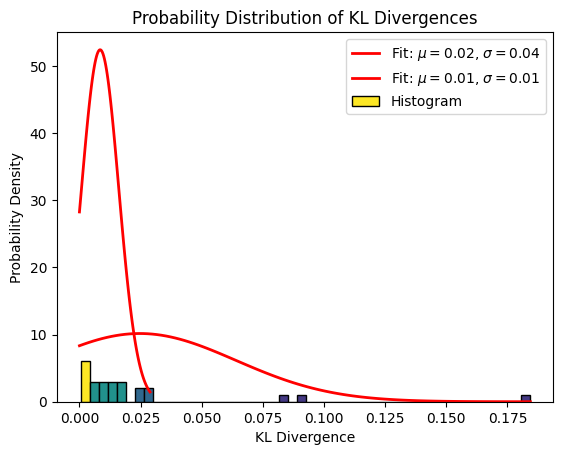

In [30]:
import pandas as pd
from scipy.stats import entropy
from scipy.stats import norm
from scipy.optimize import curve_fit

# https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

# Take the first 13 rows of df1
#df1_first_13 = all_equilibrium_df.iloc[:13]
df1_first_13 = all_df.iloc[:25]

# Take the first row of df2
reference_row = avg_df.iloc[0]
avg_df
# Compute KL divergence for each row in df1_first_13 relative to reference_row
kl_divergences = []
for index, row in df1_first_13.iterrows():
    kl_divergence = entropy(row, reference_row)
    kl_divergences.append(kl_divergence)

# Convert the list of KL divergences to a pandas Series
kl_divergences_series = pd.Series(kl_divergences, index=df1_first_13.index)

print(kl_divergences_series)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import viridis
from scipy.stats import norm
from scipy.optimize import curve_fit

# Define the number of bins
num_bins = 50

# Calculate histogram without plotting to get bin counts
counts, bins = np.histogram(kl_divergences_series, bins=num_bins)

# Get the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Normalize counts to [0, 1]
counts_normalized = counts / counts.max()

# Generate colors using Viridis colormap
colors = viridis(counts_normalized)

# Generate colors using Viridis colormap
colors = viridis(counts_normalized)

# Plot a histogram of KL divergences
plt.bar(bin_centers, counts, width=np.diff(bins), color=colors, edgecolor='black', label='Histogram')

# Fit a normal distribution to the positive side of the data
positive_data = kl_divergences_series[kl_divergences_series > 0]

# Calculate the midpoint index
midpoint_index = len(positive_data) // 2

# Take the last half of the values
last_half_positive_data = positive_data[midpoint_index:]

# Fit a normal distribution to positive side
mu, std = norm.fit(positive_data)
mu_equil, std_equil = norm.fit(last_half_positive_data)

# Plot the continuous probability distribution
x = np.linspace(0, positive_data.max(), 100)
x_equil = np.linspace(0, last_half_positive_data.max(), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2, label=f'Fit: $\mu={mu:.2f}$, $\sigma={std:.2f}$')
plt.plot(x_equil, norm.pdf(x_equil, mu_equil, std_equil), 'r-', linewidth=2, label=f'Fit: $\mu={mu_equil:.2f}$, $\sigma={std_equil:.2f}$')

plt.title('Probability Distribution of KL Divergences')
plt.xlabel('KL Divergence')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

